# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [156]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [157]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None


df_users = pd.concat([df_users_train, df_users_ex])

df_users.head()


,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


In [280]:
print(len(df_users))
print(df_users)


11947
                     uid  cls
0              202388889  1.0
1             1392518336  0.0
2              361208576  1.0
3             1535215357  1.0
4             4396196375  1.0
5               17938477  1.0
6     720288026681716737  1.0
7              174004739  1.0
8               53783678  1.0
9              257662370  1.0
10            4795355113  1.0
11            1633971270  1.0
12            2803810119  1.0
13            2244770588  1.0
14             102071251  1.0
15            3358825450  0.0
16             555940842  1.0
17            2469354073  0.0
18             360464656  0.0
19              77243076  1.0
20            1731752761  1.0
21            2330149164  0.0
22            2830586398  1.0
23             443273019  0.0
24            2591381383  0.0
25            1093716612  1.0
26              36620392  1.0
27            3437626995  1.0
28             387962514  1.0
29            2938363689  1.0
...                  ...  ...
4718          1551606846  NaN
4719

Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

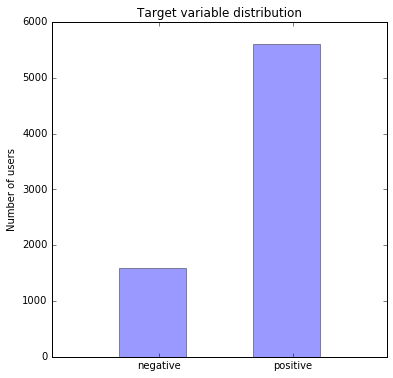

In [159]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [160]:
CONSUMER_KEY = "mB7Q0mwamNbvGFIMw8qk3efaS"
CONSUMER_SECRET = "S4FaJQGtCwbBXVr0BMYNouY4QHvV6nsp02q4C0SPwL4Q2GNwrM"

ACCESS_TOKEN_KEY = "714205612297551872-rtvMnVQ92zfuPcgUqFMOgMtgMTuror4"
ACCESS_TOKEN_SECRET = "juGh0Hn1GVuqrB9GDHotgv3tlupuQToFEWuQ5LXjFw7IZ"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [285]:
# -*- coding: utf-8 -*-
import sys
import urllib
import urllib2
import json
import codecs

DOMAIN = 'http://api.geonames.org/'
USERNAME = 'ranker'
FILENAME = 'locations_full.json'


def fetchJson(method, params):
    try:
        uri = DOMAIN + '%s?%s&username=%s' % (method, urllib.urlencode(params), USERNAME)
    except UnicodeEncodeError:
        print "Encoding failed for location"
        return None
    #print(uri)
    resource = urllib2.urlopen(uri).readlines()
    js = json.loads(resource[0])
    return js

def search(**kwargs):
    method = 'searchJSON'
    valid_kwargs = ('q', 'username', 'name_equals', 'name_startsWith', 'maxRows', 'startRow', 'country', 'countryBias', 'continentCode', 'adminCode1', 'adminCode2', 'adminCode3', 'featureClass', 'featureCode', 'lang', 'type', 'style', 'isNameRequired', 'tag', 'operator', 'charset',)
    params = {}
    for key in kwargs:
        if key in valid_kwargs:
            params[key] = kwargs[key]
    results = fetchJson(method, params)
    if not results:
        return None
    
    if 'geonames' in results:
        if len(results['geonames']):
            if 'lng' in results['geonames'][0] and 'lat' in results['geonames'][0] and 'countryName' in results['geonames'][0]:
                return [results['geonames'][0]['lng'], results['geonames'][0]['lat'], results['geonames'][0]['countryName']]
    return None
    
def get_coordinates_by_location(location):    
    return(search(**{'maxRows': 10, 'name': 'demo', 'q': location}))
# for using with files
with codecs.open(FILENAME, encoding='utf-8') as data_file:    
    locs = json.load(data_file)
    for key in locs:
        print type(key)
        locs[key] = get_coordinates_by_location(key)
        print locs[key]


<type 'unicode'>
[u'150.06278', u'-23.86194', u'Australia']
<type 'unicode'>
[u'122.07389', u'6.91028', u'Philippines']
<type 'unicode'>
None
<type 'unicode'>
None
<type 'unicode'>
[u'-85.83163', u'33.65983', u'United States']
<type 'unicode'>
[u'-73.93083', u'40.85194', u'United States']
<type 'unicode'>
None
<type 'unicode'>
[u'-74.00597', u'40.71427', u'United States']
<type 'unicode'>
None
<type 'unicode'>
None
<type 'unicode'>
Encoding failed for location
None
<type 'unicode'>
[u'-82.21069', u'36.34872', u'United States']
<type 'unicode'>
[u'-2.97794', u'53.41058', u'United Kingdom']
<type 'unicode'>
[u'-4', u'56', u'United Kingdom']
<type 'unicode'>
[u'-79.4163', u'43.70011', u'Canada']
<type 'unicode'>
[u'57.58333', u'-20.3', u'Mauritius']
<type 'unicode'>
[u'-74.45182', u'40.48622', u'United States']
<type 'unicode'>
Encoding failed for location
None
<type 'unicode'>
[u'-94.98917', u'45.05885', u'United States']
<type 'unicode'>
[u'0.11055', u'51.69815', u'United Kingdom']
<typ

KeyboardInterrupt: 

In [286]:
import tweepy
import os

ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'hw_saved_base'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        tmp = get_coordinates_by_location(user.location)
        if tmp is not None:
            record["lat"], record["lon"], record["country"] = tmp
    
    return record
#preparing 
CONSUMER_KEY = "mB7Q0mwamNbvGFIMw8qk3efaS"
CONSUMER_SECRET = "S4FaJQGtCwbBXVr0BMYNouY4QHvV6nsp02q4C0SPwL4Q2GNwrM"

ACCESS_TOKEN_KEY = "714205612297551872-rtvMnVQ92zfuPcgUqFMOgMtgMTuror4"
ACCESS_TOKEN_SECRET = "juGh0Hn1GVuqrB9GDHotgv3tlupuQToFEWuQ5LXjFw7IZ"



 # my list with ans
MAX_SIZE = 100

from math import ceil
def get_user_records(df):
    data = []
    for my_iter in range(int(ceil(len(df)/MAX_SIZE))):
        shift = my_iter * MAX_SIZE
        item = df['uid'].values[shift:shift+100].tolist()
        set_users = api.UsersLookup(user_id=item)
        for user in set_users:
            data.append(twitter_user_to_dataframe_record(user))
        json.dump({user['uid']: user for user in data}, f) 
        f.write('\n')
        print(shift)
    return data
user_records = get_user_records(df_users)

#print "Creating data frame from loaded data"
#df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
#print "Merging data frame with the training set"
#tmp = df_users[0:10]
#df_full = pd.merge(tmp, df_records, on="uid", how="left")
#print "Finished building data frame"
#print(df_records)


Encoding failed for location
Encoding failed for location
0
Encoding failed for location
100
Encoding failed for location
Encoding failed for location
200
Encoding failed for location
300
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
400
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
500
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
600
Encoding failed for location
Encoding failed for location
700
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
Encoding failed for location
800
Encoding 

In [287]:

df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])

df_full = pd.merge(df_users, df_records, on="uid", how="left")



In [288]:
#just check for the len
len(df_records)

11394

In [289]:
#ok, here we lost 11947-11394 users   it's ok

SyntaxError: invalid syntax (<ipython-input-289-9f617e5722bc>, line 1)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [291]:
t = open('res.json', 'w')
json.dump(user_records, t)

In [204]:
#here it's better to save results in file

SyntaxError: invalid syntax (<ipython-input-204-b2ed45f74494>, line 1)

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

<type 'numpy.ndarray'>


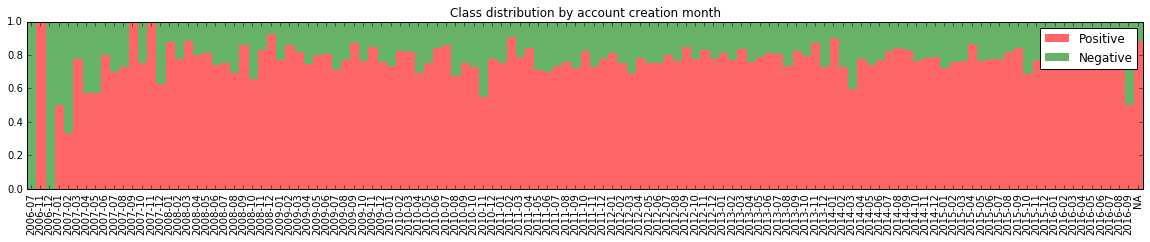

In [292]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    print(type(count_pos))
    # your code here 
    tmp = grouped["created_at"]
    for i in range(len((list(tmp)))):
        dts.append(sorted(list(tmp))[i][0])
    res_pos = grouped['cls'].sum()
    res_neg = grouped['cls'].count() - res_pos
    count_pos = res_pos
    count_neg = res_neg    
    return count_pos, count_neg, dts
grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

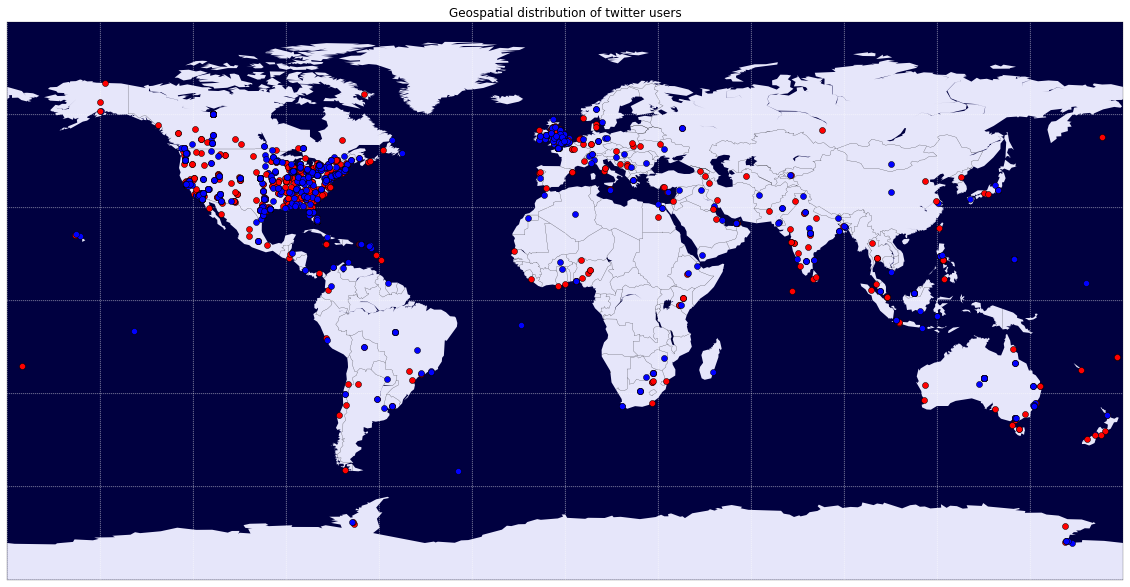

In [316]:
pl.figure(figsize=(20,12))
import math
import random
m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)
#print(df_full)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    for i in (range(len(df_full))):
        if not math.isnan(float(df_full['lat'][i])) and not math.isnan(float(df_full['lon'][i])):
            x = float(df_full['lat'][i])
            y = float(df_full['lon'][i])
            if df_full['cls'][i] == 1:
                if random.randrange(2) == 0:  
                    m.plot(x, y,'ro', alpha = 1, markersize=6)
            else:
                if random.randrange(2) == 1:  
                    m.plot(x, y,'bo', alpha = 1, markersize=6)
            
plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* ...
* ...

In [310]:
взятие точек того или иного цвета с вероятностью 1/2 позволит нам улучшить картину благодря тому, 
что мы равновероятно будем учитывать появление точки, тем самым уменьшим плотность точек на графике

SyntaxError: invalid syntax (<ipython-input-310-22d41f9aefb8>, line 1)

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

In [308]:
в исследовании данных мы используем не только среднее, но и медиану, 
так как среднее все-таки я вляется хорошей оценкой для нахождения так называемого "общего среднего", но есть большая вероятность,
что от шума это значение может пострадать, а вот значение медианы нам удостовериться и получить среднее из всего ряда значений, 
практически без влияния случайных "лишних" данных

SyntaxError: invalid syntax (<ipython-input-308-60133f75a3fa>, line 1)

In [ ]:
так как мы взяли sample, мы можем сделать оценку для популярности 

(0.0, 590458.0, 354.0, 3320.436873747495, 1.0, 175531.0, 398.0, 2411.967676767677)


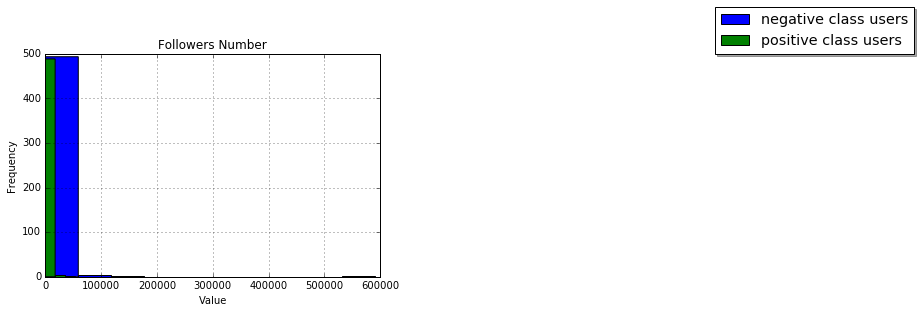

In [314]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    #Calculate min max and median. Plot histogram
    #Your code here
    min_n = users_wth_neg_class['followers_count'].min()
    max_n = users_wth_neg_class['followers_count'].max()
    med_n = users_wth_neg_class['followers_count'].median()
    mean_n = users_wth_neg_class['followers_count'].mean()
    min_p = users_wth_pos_class['followers_count'].min()
    max_p = users_wth_pos_class['followers_count'].max()
    med_p = users_wth_pos_class['followers_count'].median()
    mean_p = users_wth_pos_class['followers_count'].mean()
    print(min_n, max_n, med_n, mean_n, min_p, max_p, med_p, mean_p)
    users_wth_neg_class['followers_count'].hist(label = "negative class users")
    users_wth_pos_class['followers_count'].hist(label = "positive class users")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Followers Number')
    plt.legend(loc = (2,1), shadow=True, fontsize='x-large')
        #Calculate min max and median. Plot histogram
        #Your code here
    return
descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

In [313]:
и медиана и среднее значительно превышают значения соответствующих величин для позитивных пользователей, 
на основании этого мы можем сделать вывод, что большую популярность имеют негативные пользователи 

SyntaxError: invalid syntax (<ipython-input-313-d16fa8b9d889>, line 1)


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [300]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",-82.70343,27.74836,United States,2010-10,1055.0,1963.0,9482.0,21338.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,103.5269,1.5486,Malaysia,2013-04,1198.0,838.0,19303.0,7185.0,113.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",-2.23743,53.48095,United Kingdom,2011-08,633.0,577.0,7853.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'll be waiting here for you on this New York ...,False,Marvel. DC.,NaN,NaN,NaN,2013-06,2376.0,2436.0,187973.0,88192.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,NaN,NaN,NaN,2015-12,1245.0,972.0,37028.0,27123.0,75.0
